# NBA Player Prediction


In this project, we will use data from the 2017-2018 NBA season to predict the number of points a player scores. We will split our full dataset into training and testing sets. Then, we will perform exploratory analyses on the training set to help us gauge which features should be used in our model. We can then utilize machine learning principles to train a model that predicts the number of points per game a given player score.

Before beginning, it is important to note that we are not attempting to determine how valuable a player is to a team in the way that metrics such as win shares and value over replacement attempt to do. We are simply attempting to create a model that takes in a player's statistics and guesses how many points per game he will score.

## Importing Libraries

In [0]:
# Linear algebra
import numpy as np

# Data processing
import pandas as pd

# Data visualization
import seaborn as sns
sns.set()

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# Algorithms to use:
# Linear regression (Simple, Multiple, and Polynomial)
# Lasso
# Ridge
# Decision tree regression
# Random forest trees
# Gradient boosted trees
# Elastic net regression
# https://www.analyticsvidhya.com/blog/2015/08/comprehensive-guide-regression/

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score as EVS, mean_squared_error as MSE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading the Data

In [0]:
# Extra data on players 'https://raw.githubusercontent.com/evanpfeifer/nba-player-data/master/Players.csv'
# Extra data on players 'https://raw.githubusercontent.com/evanpfeifer/nba-player-data/master/player_data.csv'
url = 'https://raw.githubusercontent.com/evanpfeifer/nba-player-data/master/Seasons_Stats.csv'
df = pd.read_csv(url)

In [0]:
df.loc[df.Player=="James Harden"]

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
20133,20133,2010.0,James Harden,SG,20.0,OKC,76.0,0.0,1738.0,14.0,0.551,0.429,0.415,3.2,12.7,8.1,12.3,2.4,0.9,13.4,20.4,NaN,2.0,2.5,4.5,0.124,NaN,0.7,0.3,1.0,1.3,233.0,578.0,0.403,93.0,248.0,0.375,140.0,330.0,0.424,0.484,194.0,240.0,0.808,47.0,197.0,244.0,137.0,80.0,20.0,106.0,200.0,753.0
20766,20766,2011.0,James Harden,SG,21.0,OKC,82.0,5.0,2189.0,16.4,0.598,0.474,0.501,2.3,11.0,6.8,12.8,2.2,0.8,11.3,19.5,NaN,5.0,2.1,7.1,0.156,NaN,2.9,-0.6,2.3,2.4,298.0,684.0,0.436,113.0,324.0,0.349,185.0,360.0,0.514,0.518,289.0,343.0,0.843,42.0,213.0,255.0,176.0,92.0,24.0,106.0,207.0,998.0
21338,21338,2012.0,James Harden,SG,22.0,OKC,62.0,2.0,1946.0,21.1,0.660,0.464,0.587,1.9,12.2,7.4,19.3,1.6,0.6,14.8,21.6,NaN,7.5,1.8,9.3,0.230,NaN,5.6,-1.1,4.5,3.2,309.0,629.0,0.491,114.0,292.0,0.390,195.0,337.0,0.579,0.582,312.0,369.0,0.846,30.0,222.0,252.0,229.0,62.0,15.0,137.0,150.0,1044.0
21886,21886,2013.0,James Harden,SG,23.0,HOU,78.0,78.0,2985.0,23.0,0.600,0.364,0.592,2.4,11.9,7.2,25.7,2.4,1.0,14.9,29.0,NaN,9.8,3.0,12.8,0.206,NaN,5.4,0.1,5.5,5.7,585.0,1337.0,0.438,179.0,486.0,0.368,406.0,851.0,0.477,0.504,674.0,792.0,0.851,62.0,317.0,379.0,455.0,142.0,38.0,295.0,178.0,2023.0
22504,22504,2014.0,James Harden,SG,24.0,HOU,73.0,73.0,2777.0,23.5,0.618,0.401,0.552,2.6,10.7,6.9,27.3,2.1,0.8,15.0,27.8,NaN,10.1,2.7,12.8,0.221,NaN,6.2,-0.5,5.7,5.4,549.0,1205.0,0.456,177.0,483.0,0.366,372.0,722.0,0.515,0.529,576.0,665.0,0.866,61.0,283.0,344.0,446.0,115.0,29.0,265.0,177.0,1851.0
23114,23114,2015.0,James Harden,SG,25.0,HOU,81.0,81.0,2981.0,26.7,0.605,0.378,0.561,2.8,14.2,8.5,34.6,2.6,1.6,14.9,31.3,NaN,12.2,4.2,16.4,0.265,NaN,7.4,1.0,8.4,7.8,647.0,1470.0,0.440,208.0,555.0,0.375,439.0,915.0,0.480,0.511,715.0,824.0,0.868,75.0,384.0,459.0,565.0,154.0,60.0,321.0,208.0,2217.0
23722,23722,2016.0,James Harden,SG,26.0,HOU,82.0,82.0,3125.0,25.3,0.598,0.406,0.518,2.2,15.6,8.8,35.4,2.2,1.4,15.9,32.5,NaN,10.7,2.6,13.3,0.204,NaN,7.1,-0.4,6.7,6.9,710.0,1617.0,0.439,236.0,657.0,0.359,474.0,960.0,0.494,0.512,720.0,837.0,0.860,63.0,438.0,501.0,612.0,139.0,51.0,374.0,229.0,2376.0
24306,24306,2017.0,James Harden,PG,27.0,HOU,81.0,81.0,2947.0,27.3,0.613,0.493,0.575,3.5,20.9,12.2,50.7,2.0,1.0,19.5,34.2,NaN,11.5,3.6,15.0,0.245,NaN,8.7,1.5,10.1,9.0,674.0,1533.0,0.440,262.0,756.0,0.347,412.0,777.0,0.530,0.525,746.0,881.0,0.847,95.0,564.0,659.0,906.0,120.0,37.0,464.0,215.0,2356.0


## Cleaning

In [0]:
# Filter for 2017/2018 season
df = df[df['Year'] == 2017]
df.head()


,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
24096,24096,2017.0,Alex Abrines,SG,23.0,OKC,68.0,6.0,1055.0,10.1,0.560,0.724,0.144,1.9,7.1,4.5,5.5,1.7,0.6,8.3,15.9,NaN,1.2,0.9,2.1,0.095,NaN,-0.3,-2.2,-2.5,-0.1,134.0,341.0,0.393,94.0,247.0,0.381,40.0,94.0,0.426,0.531,44.0,49.0,0.898,18.0,68.0,86.0,40.0,37.0,8.0,33.0,114.0,406.0
24097,24097,2017.0,Quincy Acy,PF,26.0,TOT,38.0,1.0,558.0,11.8,0.565,0.529,0.353,3.9,18.0,11.0,4.9,1.2,2.0,9.7,16.8,NaN,0.5,0.5,0.9,0.082,NaN,-1.8,-1.2,-3.0,-0.1,70.0,170.0,0.412,37.0,90.0,0.411,33.0,80.0,0.413,0.521,45.0,60.0,0.750,20.0,95.0,115.0,18.0,14.0,15.0,21.0,67.0,222.0
24098,24098,2017.0,Quincy Acy,PF,26.0,DAL,6.0,0.0,48.0,-1.4,0.355,0.412,0.176,4.6,15.2,9.7,0.0,0.0,0.0,9.8,20.0,NaN,-0.2,0.0,-0.1,-0.133,NaN,-10.1,-6.0,-16.2,-0.2,5.0,17.0,0.294,1.0,7.0,0.143,4.0,10.0,0.400,0.324,2.0,3.0,0.667,2.0,6.0,8.0,0.0,0.0,0.0,2.0,9.0,13.0
24099,24099,2017.0,Quincy Acy,PF,26.0,BRK,32.0,1.0,510.0,13.1,0.587,0.542,0.373,3.8,18.2,11.1,5.4,1.3,2.2,9.6,16.5,NaN,0.6,0.5,1.1,0.102,NaN,-1.1,-0.7,-1.8,0.0,65.0,153.0,0.425,36.0,83.0,0.434,29.0,70.0,0.414,0.542,43.0,57.0,0.754,18.0,89.0,107.0,18.0,14.0,15.0,19.0,58.0,209.0
24100,24100,2017.0,Steven Adams,C,23.0,OKC,80.0,80.0,2389.0,16.5,0.589,0.002,0.392,13.0,15.5,14.2,5.4,1.8,2.6,16.0,16.2,NaN,3.3,3.1,6.4,0.130,NaN,-0.7,1.2,0.5,1.5,374.0,655.0,0.571,0.0,1.0,0.000,374.0,654.0,0.572,0.571,157.0,257.0,0.611,282.0,333.0,615.0,86.0,88.0,78.0,146.0,195.0,905.0


Here we can see that a player can span multiple rows if they played for more than one team during the season. We are going to disregard the team(s) that any given player played for so that we have one row per player during the season. Whenever a player played for more than one team, they have a row with team name "TOT" that gives their overall statistics across all teams they played for.

In [0]:
df.loc[df.Player == 'Ersan Ilyasova']

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
24354,24354,2017.0,Ersan Ilyasova,PF,29.0,TOT,82.0,52.0,2142.0,14.6,0.546,0.452,0.233,5.9,18.8,12.4,11.0,1.3,0.9,10.6,22.2,NaN,1.8,2.3,4.1,0.091,NaN,0.3,-0.8,-0.5,0.8,384.0,890.0,0.431,142.0,402.0,0.353,242.0,488.0,0.496,0.511,161.0,207.0,0.778,115.0,366.0,481.0,141.0,58.0,23.0,116.0,211.0,1071.0
24355,24355,2017.0,Ersan Ilyasova,PF,29.0,OKC,3.0,0.0,62.0,6.9,0.469,0.750,0.000,3.6,25.0,14.3,2.2,2.4,1.3,20.0,13.7,NaN,-0.1,0.1,0.0,0.012,NaN,-5.8,-0.4,-6.3,-0.1,6.0,16.0,0.375,3.0,12.0,0.250,3.0,4.0,0.750,0.469,0.0,0.0,NaN,2.0,14.0,16.0,1.0,3.0,1.0,4.0,5.0,15.0
24356,24356,2017.0,Ersan Ilyasova,PF,29.0,PHI,53.0,40.0,1447.0,15.4,0.553,0.460,0.219,5.4,18.5,12.0,11.5,1.1,0.8,9.9,23.6,NaN,1.4,1.3,2.6,0.087,NaN,0.9,-1.3,-0.4,0.6,285.0,648.0,0.440,107.0,298.0,0.359,178.0,350.0,0.509,0.522,109.0,142.0,0.768,71.0,243.0,314.0,97.0,33.0,14.0,78.0,133.0,786.0
24357,24357,2017.0,Ersan Ilyasova,PF,29.0,ATL,26.0,12.0,633.0,13.5,0.530,0.407,0.288,7.4,18.7,13.1,10.6,1.7,1.1,11.8,19.9,NaN,0.5,0.9,1.4,0.106,NaN,-0.6,0.5,-0.2,0.3,93.0,226.0,0.412,32.0,92.0,0.348,61.0,134.0,0.455,0.482,52.0,65.0,0.800,42.0,109.0,151.0,43.0,22.0,8.0,34.0,73.0,270.0


In [0]:
# Include only "TOT" for players who played for multiple teams
tot_df = df.loc[df.Tm=='TOT']
players2 = tot_df['Player']
df.drop(tot_df.index + 1, axis=0, inplace=True)
df.drop(tot_df.index + 2, axis=0, inplace=True)
df.drop(24357, axis=0, inplace=True)
df.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
24096,24096,2017.0,Alex Abrines,SG,23.0,OKC,68.0,6.0,1055.0,10.1,0.560,0.724,0.144,1.9,7.1,4.5,5.5,1.7,0.6,8.3,15.9,NaN,1.2,0.9,2.1,0.095,NaN,-0.3,-2.2,-2.5,-0.1,134.0,341.0,0.393,94.0,247.0,0.381,40.0,94.0,0.426,0.531,44.0,49.0,0.898,18.0,68.0,86.0,40.0,37.0,8.0,33.0,114.0,406.0
24097,24097,2017.0,Quincy Acy,PF,26.0,TOT,38.0,1.0,558.0,11.8,0.565,0.529,0.353,3.9,18.0,11.0,4.9,1.2,2.0,9.7,16.8,NaN,0.5,0.5,0.9,0.082,NaN,-1.8,-1.2,-3.0,-0.1,70.0,170.0,0.412,37.0,90.0,0.411,33.0,80.0,0.413,0.521,45.0,60.0,0.750,20.0,95.0,115.0,18.0,14.0,15.0,21.0,67.0,222.0
24100,24100,2017.0,Steven Adams,C,23.0,OKC,80.0,80.0,2389.0,16.5,0.589,0.002,0.392,13.0,15.5,14.2,5.4,1.8,2.6,16.0,16.2,NaN,3.3,3.1,6.4,0.130,NaN,-0.7,1.2,0.5,1.5,374.0,655.0,0.571,0.0,1.0,0.000,374.0,654.0,0.572,0.571,157.0,257.0,0.611,282.0,333.0,615.0,86.0,88.0,78.0,146.0,195.0,905.0
24101,24101,2017.0,Arron Afflalo,SG,31.0,SAC,61.0,45.0,1580.0,9.0,0.559,0.360,0.221,0.7,8.4,4.6,7.4,0.7,0.4,8.4,14.4,NaN,1.2,0.2,1.4,0.043,NaN,-1.4,-2.0,-3.5,-0.6,185.0,420.0,0.440,62.0,151.0,0.411,123.0,269.0,0.457,0.514,83.0,93.0,0.892,9.0,116.0,125.0,78.0,21.0,7.0,42.0,104.0,515.0
24102,24102,2017.0,Alexis Ajinca,C,28.0,NOP,39.0,15.0,584.0,12.9,0.529,0.022,0.225,8.3,23.8,16.0,3.1,1.7,3.1,13.7,17.2,NaN,0.0,0.9,1.0,0.080,NaN,-5.1,1.0,-4.1,-0.3,89.0,178.0,0.500,0.0,4.0,0.000,89.0,174.0,0.511,0.500,29.0,40.0,0.725,46.0,131.0,177.0,12.0,20.0,22.0,31.0,77.0,207.0


We'll first select some initial features, likely more than will be used in the final model in order to give us some wiggle room. We have not included many metrics that attempt to quanitify a player's overall value to the team, such as value over replacement (VORP) or win shares, as these are quite unlikely to provide much about whether a player will score many points. Likewise, we have left out some defense focussed features.

All features we selected:
* Pos: position
* Age: player age
* Tm: team
* G: games
* MP: minutes played per game
* PER: player efficiency rating
* TS%: true shooting %
* TRB%: total rebound %
* STL%: steal %
* TOV%: turnover %
* FGA: field goal attempts per game
* 3P: 3-point field goals
* 3P%: 3-point field goal percentage
* 2P: 2-point field goals
* 2P%: 2-point field goal percentage
* eFG%: effective field goal percentage
* PTS: points per game


In [0]:

features = ['Player', 'Pos', 'Age', 'G', 'MP', 'PER', 'TS%', 'TRB%', 'STL%', 'TOV%', 'FGA', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'PTS']

df = df[features]

# Change minutes played, FG attempts, and points to be per game
df['MP'] = df['MP'] / df['G']
df['FGA'] = df['FGA'] / df['G']
df['PTS'] = df['PTS'] / df['G']

df.head()

,Player,Pos,Age,G,MP,PER,TS%,TRB%,STL%,TOV%,FGA,3P,3PA,3P%,2P,2PA,2P%,eFG%,PTS
24096,Alex Abrines,SG,23.0,68.0,15.514706,10.1,0.560,4.5,1.7,8.3,5.014706,94.0,247.0,0.381,40.0,94.0,0.426,0.531,5.970588
24097,Quincy Acy,PF,26.0,38.0,14.684211,11.8,0.565,11.0,1.2,9.7,4.473684,37.0,90.0,0.411,33.0,80.0,0.413,0.521,5.842105
24100,Steven Adams,C,23.0,80.0,29.862500,16.5,0.589,14.2,1.8,16.0,8.187500,0.0,1.0,0.000,374.0,654.0,0.572,0.571,11.312500
24101,Arron Afflalo,SG,31.0,61.0,25.901639,9.0,0.559,4.6,0.7,8.4,6.885246,62.0,151.0,0.411,123.0,269.0,0.457,0.514,8.442623
24102,Alexis Ajinca,C,28.0,39.0,14.974359,12.9,0.529,16.0,1.7,13.7,4.564103,0.0,4.0,0.000,89.0,174.0,0.511,0.500,5.307692


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 24096 to 24690
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  488 non-null    object 
 1   Pos     488 non-null    object 
 2   Age     488 non-null    float64
 3   G       488 non-null    float64
 4   MP      488 non-null    float64
 5   PER     488 non-null    float64
 6   TS%     487 non-null    float64
 7   TRB%    488 non-null    float64
 8   STL%    488 non-null    float64
 9   TOV%    487 non-null    float64
 10  FGA     488 non-null    float64
 11  3P      488 non-null    float64
 12  3PA     488 non-null    float64
 13  3P%     452 non-null    float64
 14  2P      488 non-null    float64
 15  2PA     488 non-null    float64
 16  2P%     486 non-null    float64
 17  eFG%    487 non-null    float64
 18  PTS     488 non-null    float64
dtypes: float64(17), object(2)
memory usage: 76.2+ KB


Note that there are some missing values for 2 and 3-point percentages, despite no missing values for 2 and 3-point attempts or baskets made. After some snooping, it can be discovered that these NaN values are a result of a division by zero error. Since 2 and 3-point percentages are calculated by dividing attempts made by total attempts, if a player made no 3 point attempts, the resulting 3-point percentage is NaN. We don't want to simply drop all players that didn't make any 3-point attempts, because players like Boban Marjanovic (who took no 3-point attempts that season) are inarguably important for a team's scoring. To get around this, we can simply find which players had no 3-point attempts and give them 3-point percentage values of 0.

In [0]:
df.loc[df['3PA'] == 0, '3P%'] = 0
df.loc[df['2PA'] == 0, '2P%'] = 0

In [0]:
df[df.isna().any(axis=1)]

,Player,Pos,Age,G,MP,PER,TS%,TRB%,STL%,TOV%,FGA,3P,3PA,3P%,2P,2PA,2P%,eFG%,PTS
24344,Danuel House,SG,23.0,1.0,1.0,12.2,NaN,56.4,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


Quite remarkably, we now only have one player with missing data. Given the fact that Danuel House had barely any play time with no points, it's okay to drop him entirely from the dataset.

In [0]:
df.drop([24344], inplace=True)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 24096 to 24690
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  487 non-null    object 
 1   Pos     487 non-null    object 
 2   Age     487 non-null    float64
 3   G       487 non-null    float64
 4   MP      487 non-null    float64
 5   PER     487 non-null    float64
 6   TS%     487 non-null    float64
 7   TRB%    487 non-null    float64
 8   STL%    487 non-null    float64
 9   TOV%    487 non-null    float64
 10  FGA     487 non-null    float64
 11  3P      487 non-null    float64
 12  3PA     487 non-null    float64
 13  3P%     487 non-null    float64
 14  2P      487 non-null    float64
 15  2PA     487 non-null    float64
 16  2P%     487 non-null    float64
 17  eFG%    487 non-null    float64
 18  PTS     487 non-null    float64
dtypes: float64(17), object(2)
memory usage: 76.1+ KB


## Train/Test Splitting

We will be employing cross-validation in order to tune hyperparameters in our models, thus eliminating the need for a separate validation set.

As is common practice, we will use 80% of our data for training and the final 20% for testiIn order to manually obtain train and test sets, we'll shuffle the rows by sampling radomply without replacement, then take the first 390 (60%) players to form out training set, and the remaining 97 will form the test set.

In [0]:
shuffled = df.sample(frac=1, replace=False, random_state=1)
train_df = shuffled.iloc[np.arange(390)]
test_df = shuffled.iloc[np.arange(390, 487)]

In [0]:
train_df.head()

,Player,Pos,Age,G,MP,PER,TS%,TRB%,STL%,TOV%,FGA,3P,3PA,3P%,2P,2PA,2P%,eFG%,PTS
24275,Rudy Gay,SF,30.0,30.0,33.766667,17.9,0.559,10.8,2.2,12.8,14.733333,42.0,113.0,0.372,159.0,329.0,0.483,0.502,18.733333
24265,Randy Foye,SG,33.0,69.0,18.608696,7.3,0.506,6.4,1.3,18.5,4.710145,67.0,203.0,0.330,51.0,122.0,0.418,0.466,5.173913
24298,Draymond Green,PF,26.0,76.0,32.513158,16.5,0.522,13.3,3.0,19.8,8.552632,81.0,263.0,0.308,191.0,387.0,0.494,0.481,10.210526
24592,Tony Snell,SG,25.0,80.0,29.200000,9.7,0.603,6.2,1.2,8.8,6.762500,144.0,355.0,0.406,102.0,186.0,0.548,0.588,8.537500
24341,Richaun Holmes,C,23.0,57.0,20.929825,18.6,0.611,14.4,1.7,10.7,7.228070,27.0,77.0,0.351,203.0,335.0,0.606,0.591,9.807018


In [0]:
# Top ten players by PPG
train_df.sort_values(by=['PTS'], ascending=False).head(10)

,Player,Pos,Age,G,MP,PER,TS%,TRB%,STL%,TOV%,FGA,3P,3PA,3P%,2P,2PA,2P%,eFG%,PTS
24654,Russell Westbrook,PG,28.0,81.0,34.592593,30.6,0.554,17.1,2.3,15.9,23.962963,200.0,583.0,0.343,624.0,1358.0,0.459,0.476,31.580247
24306,James Harden,PG,27.0,81.0,36.382716,27.3,0.613,12.2,2.0,19.5,18.925926,262.0,756.0,0.347,412.0,777.0,0.530,0.525,29.086420
24612,Isaiah Thomas,PG,27.0,76.0,33.802632,26.5,0.625,4.4,1.4,10.7,19.381579,245.0,646.0,0.379,437.0,827.0,0.528,0.546,28.934211
24218,Anthony Davis,C,23.0,75.0,36.106667,27.5,0.579,17.3,1.7,9.1,20.360000,40.0,134.0,0.299,730.0,1393.0,0.524,0.517,27.986667
24226,DeMar DeRozan,SG,27.0,74.0,35.405405,24.0,0.552,8.3,1.5,9.0,20.878378,33.0,124.0,0.266,688.0,1421.0,0.484,0.477,27.297297
24206,DeMarcus Cousins,C,26.0,72.0,34.236111,25.7,0.562,18.2,2.0,13.5,19.902778,131.0,364.0,0.360,516.0,1069.0,0.483,0.497,26.972222
24365,LeBron James,SF,32.0,74.0,37.756757,27.0,0.619,12.6,1.6,16.1,18.162162,124.0,342.0,0.363,612.0,1002.0,0.611,0.594,26.405405
24414,Kawhi Leonard,SF,25.0,74.0,33.432432,27.5,0.611,9.8,2.7,9.1,17.716216,147.0,386.0,0.381,489.0,925.0,0.529,0.541,25.513514
24216,Stephen Curry,PG,28.0,79.0,33.392405,24.6,0.624,7.3,2.6,13.0,18.265823,324.0,789.0,0.411,351.0,654.0,0.537,0.580,25.303797
24360,Kyrie Irving,PG,24.0,72.0,35.069444,23.0,0.580,5.0,1.6,10.3,19.722222,177.0,441.0,0.401,494.0,979.0,0.505,0.535,25.222222


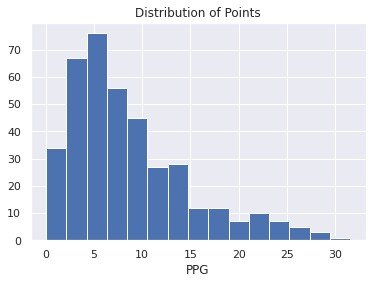

In [0]:
# Distribution of points
plt.hist(train_df['PTS'], bins=15)
plt.title('Distribution of Points')
plt.xlabel('PPG')
plt.show()

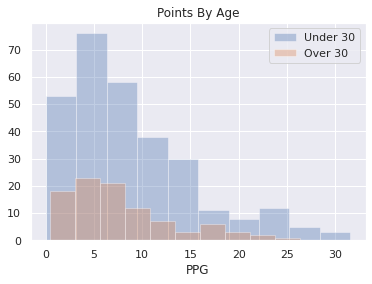

In [0]:
# Comparing PPG for players over & under 30
under_30 = train_df.loc[train_df.Age < 30].PTS
over_30 = train_df.loc[train_df.Age >= 30].PTS

plt.hist(x=under_30, alpha=0.35, label='Under 30')
plt.hist(x=over_30, alpha=0.35, label='Over 30')
plt.legend()
plt.xlabel('PPG')
plt.title('Points By Age')
plt.show() 

Since the PTS distribution for players under 30 and over 30 follow the same pattern there no need to examine them differently

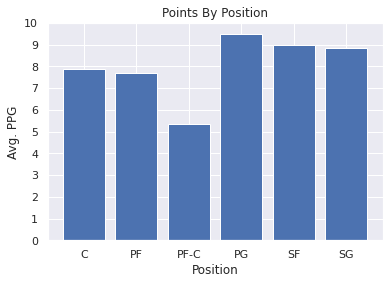

In [0]:
# Average points by position 
grouped_position = train_df[['Pos', 'PTS']].groupby(by=['Pos']).mean()

plt.bar(grouped_position.index, height=grouped_position.PTS)
plt.xlabel('Position')
plt.ylabel('Avg. PPG')
plt.title('Points By Position')
plt.yticks(np.arange(0, 11))
plt.show()

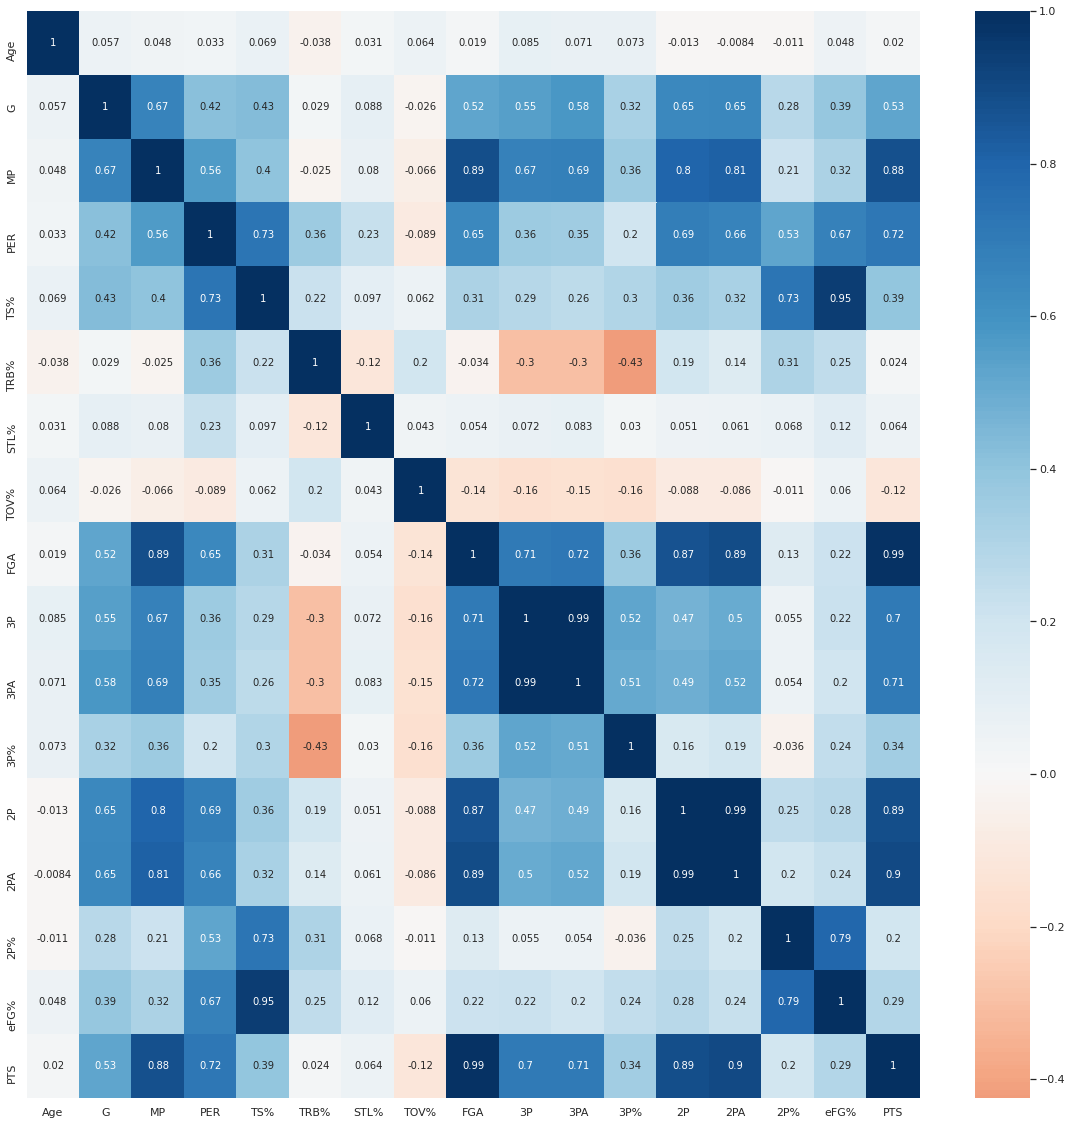

In [0]:
plt.figure(figsize=(20, 20))
sns.heatmap(train_df.corr(), annot=True, center=0, cmap="RdBu")
plt.show()

R-squared: 0.7667192657378216


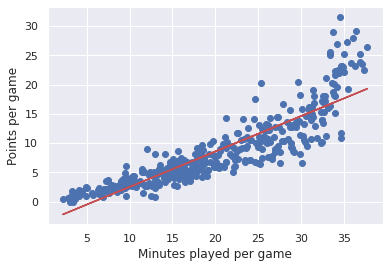

In [0]:



# scatter plots of points per game against minutes played per game
plt.scatter(train_df["MP"],train_df["PTS"])
plt.xlabel("Minutes played per game")
plt.ylabel("Points per game")
Linear_model = LinearRegression()
Linear_model.fit(train_df[["MP"]], train_df[["PTS"]])
mp_predict = Linear_model.predict(train_df[["MP"]])
plt.plot(train_df["MP"], mp_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["MP"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.5179211452749585


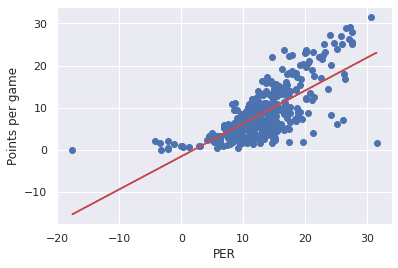

In [0]:
# scatter plots of points per game against PER
plt.scatter(train_df["PER"], train_df["PTS"])
plt.xlabel("PER")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["PER"]], train_df[["PTS"]])
per_predict = Linear_model.predict(train_df[["PER"]])
plt.plot(train_df["PER"], per_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["PER"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.15565307811049378


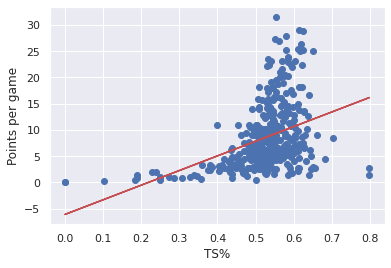

In [0]:

# scatter plots of points per game against TS%
plt.scatter(train_df["TS%"], train_df["PTS"])
plt.xlabel("TS%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["TS%"]], train_df[["PTS"]])
ts_predict = Linear_model.predict(train_df[["TS%"]])
plt.plot(train_df["TS%"], ts_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["TS%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.0005915311575651616


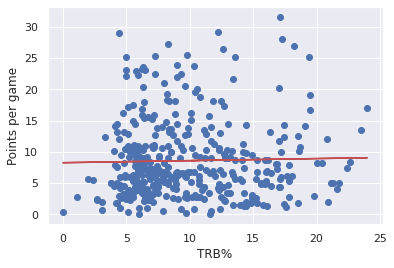

In [0]:
# scatter plots of points per game against TRB%
plt.scatter(train_df["TRB%"], train_df["PTS"])
plt.xlabel("TRB%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["TRB%"]], train_df[["PTS"]])
trb_predict = Linear_model.predict(train_df[["TRB%"]])
plt.plot(train_df["TRB%"], trb_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["TRB%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.004062778429081426


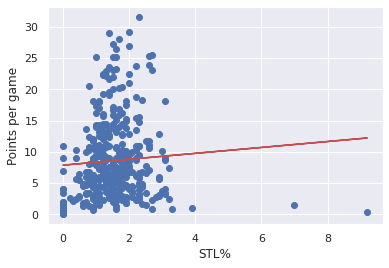

In [0]:
# scatter plots of points per game against STL%
plt.scatter(train_df["STL%"], train_df["PTS"])
plt.xlabel("STL%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["STL%"]], train_df[["PTS"]])
stl_predict = Linear_model.predict(train_df[["STL%"]])
plt.plot(train_df["STL%"], stl_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["STL%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.015061990476007536


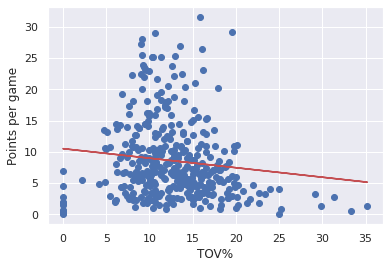

In [0]:
# scatter plots of points per game against TOV%
plt.scatter(train_df["TOV%"], train_df["PTS"])
plt.xlabel("TOV%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["TOV%"]], train_df[["PTS"]])
tov_predict = Linear_model.predict(train_df[["TOV%"]])
plt.plot(train_df["TOV%"], tov_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["TOV%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.9706213056177363


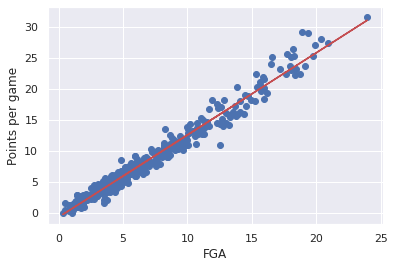

In [0]:

# scatter plots of points per game against FGA
plt.scatter(train_df["FGA"], train_df["PTS"])
plt.xlabel("FGA")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["FGA"]], train_df[["PTS"]])
fga_predict = Linear_model.predict(train_df[["FGA"]])
plt.plot(train_df["FGA"], fga_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["FGA"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.11897836939624407


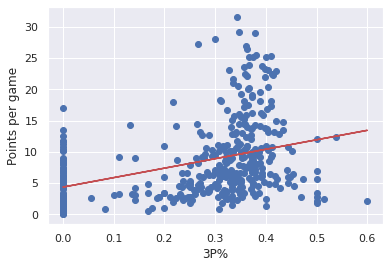

In [0]:
# scatter plots of points per game against 3P%
plt.scatter(train_df["3P%"], train_df["PTS"])
plt.xlabel("3P%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["3P%"]], train_df[["PTS"]])
threep_predict = Linear_model.predict(train_df[["3P%"]])
plt.plot(train_df["3P%"], threep_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["3P%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.038932805457997044


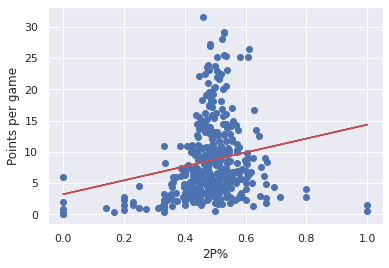

In [0]:
# scatter plots of points per game against 2P%
plt.scatter(train_df["2P%"], train_df["PTS"])
plt.xlabel("2P%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["2P%"]], train_df[["PTS"]])
twop_predict = Linear_model.predict(train_df[["2P%"]])
plt.plot(train_df["2P%"], twop_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["2P%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.08354007281772402


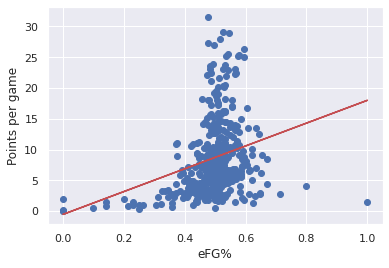

In [0]:
# scatter plots of points per game against eFG%
plt.scatter(train_df["eFG%"], train_df["PTS"])
plt.xlabel("eFG%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["eFG%"]], train_df[["PTS"]])
efg_predict = Linear_model.predict(train_df[["eFG%"]])
plt.plot(train_df["eFG%"], efg_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["eFG%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.5042844231517125


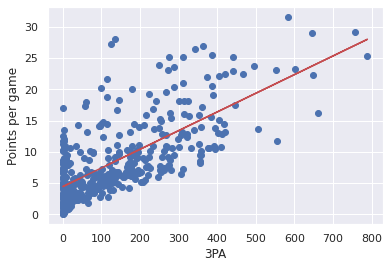

In [0]:
# scatter plots of points per game against 3PA
plt.scatter(train_df["3PA"], train_df["PTS"])
plt.xlabel("3PA")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["3PA"]], train_df[["PTS"]])
TPA_predict = Linear_model.predict(train_df[["3PA"]])
plt.plot(train_df["3PA"], TPA_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["3PA"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.8020962690292562


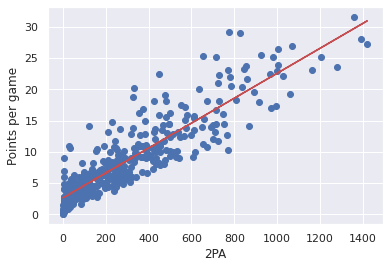

In [0]:
# scatter plots of points per game against 2PA
plt.scatter(train_df["2PA"], train_df["PTS"])
plt.xlabel("2PA")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["2PA"]], train_df[["PTS"]])
TWPA_predict = Linear_model.predict(train_df[["2PA"]])
plt.plot(train_df["2PA"], TWPA_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["2PA"]], train_df[["PTS"]]))

R-squared: 0.2699819418100212
VIF value: 1.369829127897767


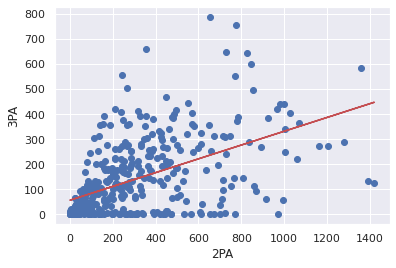

In [0]:
# scatter plots of 2PA against 3PA
plt.scatter(train_df["2PA"], train_df["3PA"])
plt.xlabel("2PA")
plt.ylabel("3PA")
Linear_model.fit(train_df[["2PA"]], train_df[["3PA"]])
TWTPA_predict = Linear_model.predict(train_df[["2PA"]])
plt.plot(train_df["2PA"], TWTPA_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["2PA"]], train_df[["3PA"]]))
print("VIF value:", 1/(1-Linear_model.score(train_df[["2PA"]], train_df[["3PA"]]))) #check for collinearity of the variables since it's smaller than 4 there is no problem 

R-squared: 0.7959510797304998
VIF value: 4.900785550245684


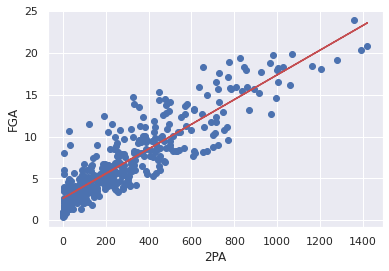

In [0]:
# scatter plots of 2PA against FGA
plt.scatter(train_df["2PA"], train_df["FGA"])
plt.xlabel("2PA")
plt.ylabel("FGA")
Linear_model.fit(train_df[["2PA"]], train_df[["FGA"]])
TWFPA_predict = Linear_model.predict(train_df[["2PA"]])
plt.plot(train_df["2PA"], TWFPA_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["2PA"]], train_df[["FGA"]]))
print("VIF value:", 1/(1-Linear_model.score(train_df[["2PA"]], train_df[["FGA"]]))) #check for collinearity of the variables since it's bigger than 4 there is a problem 

R-squared: 0.5172743482913011
VIF value: 2.071570044931962


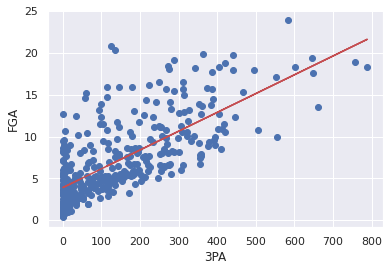

In [0]:
# scatter plots of 2PA against FGA
plt.scatter(train_df["3PA"], train_df["FGA"])
plt.xlabel("3PA")
plt.ylabel("FGA")
Linear_model.fit(train_df[["3PA"]], train_df[["FGA"]])
TWFPA_predict = Linear_model.predict(train_df[["3PA"]])
plt.plot(train_df["3PA"], TWFPA_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["3PA"]], train_df[["FGA"]]))
print("VIF value:", 1/(1-Linear_model.score(train_df[["3PA"]], train_df[["FGA"]]))) #check for collinearity of the variables since it's smaller than 4 there is no problem 

In a lienar model with multiple variables, when two features are strongly linearly correlated then there is the problem of collinearity which states that when some of the features are strongly linearly correlated, then one of them tend to either provide useless/repetitive information or simply just cause some error/bias. In this case, when we examine the variables 2PA and FGA, they are highly linearly correlated and with a VIF value of over 4. Hence, we conclude that they are strongly linearly correlated and may cause the problem of linear collinearity if we include both variables in the model. After deleting 2PA from our model it turns out that not only the MSE value decreases, but also the r-squared value increases.

## Machine Learning Models

Now that we have done our initial analyses, we can choose features to use in the model. We will make a fair amount of models using different algorithms and compare them to see which is best.

From our exploratory analyses and visualizations, it appears that some of our features are more important than others. To avoid overfitting and make our model as efficient as possible, we will use the following features in our final model:
* MP: minutes played
* PER: player efficiency rating
* FGA: field goal attempts
* 3PA: 3-point attempts

In [0]:
x_train = train_df[['MP','FGA', 'PER','3PA']]
y_train = train_df[['PTS']]

x_test = test_df[['MP', 'FGA', 'PER', '3PA']]
y_test = test_df[['PTS']]

In [0]:
#cost function for multiple variable linear regression
def costFunction(X,y, theta):
  m=len(y)
  J=0
  J=(1/2*m)*multiply((np.transpose(multiply(theta, X)-y)), multiply(theta, X)-y)
  return J

### Linear Regression

In [0]:
# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

# Predict
lin_y_pred = lin_reg.predict(x_test)

# MSE
lr_mse = MSE(y_test, lin_y_pred)
print('MSE:', lr_mse)

# r-squared value
lr_rsquared = r2_score(y_test, lin_y_pred)
print('R^2:', lr_rsquared)

# Display results
lr_df = pd.DataFrame({'Actual': np.array(y_test['PTS']), 'Predicted': lin_y_pred.flatten()}, 
                     index=test_df['Player'])

lr_df.round(1).head()



MSE: 1.0084119370903002
R^2: 0.9598072092497385


,Actual,Predicted
Player,,
Lamar Patterson,1.8,1.3
Ryan Kelly,1.6,1.4
Troy Williams,6.2,6.1
Mike Conley,20.5,19.5
DeAndre Jordan,12.7,9.9


### Ridge Regression

In [0]:
# Ridge regression is least squares with l2 regularization.

# Fit ridge regression model
ridge = Ridge()
ridge.fit(x_train, y_train)

# Predict
ridge_predict = ridge.predict(x_test)

# MSE
ridge_mse = MSE(y_test, ridge_predict)
print('MSE:', ridge_mse)

# r squared value
ridge_rsquared = r2_score(y_test, ridge_predict)
print('R^2:', ridge_rsquared)

# Display results
lr1_df=pd.DataFrame({"Actual": np.array(y_test["PTS"]), "Predicted": ridge_predict.flatten()}, index=test_df['Player'])

lr1_df.round(1).head()


MSE: 1.0078252865871993
R^2: 0.9598305916791281


,Actual,Predicted
Player,,
Lamar Patterson,1.8,1.3
Ryan Kelly,1.6,1.4
Troy Williams,6.2,6.1
Mike Conley,20.5,19.5
DeAndre Jordan,12.7,9.9


### Decision Tree Regression

In [0]:
# Fit decision tree regression model
dt_reg = DecisionTreeRegressor(max_depth=5)
dt_reg.fit(x_train, y_train)

# Predict
dt_y_pred = dt_reg.predict(x_test)

# MSE
dt_mse = MSE(y_test, dt_y_pred)
print('MSE:', dt_mse)

# r-squared value
dt_rsquared = r2_score(y_test, dt_y_pred)
print('R^2:', dt_rsquared)

MSE: 1.723269812990595
R^2: 0.9313147529772141


In [0]:
# Display results
dt_df = pd.DataFrame({'Actual': np.array(y_test['PTS']), 'Predicted': dt_y_pred.flatten()}, 
                     index=test_df['Player'])

dt_df.round(1).head()

,Actual,Predicted
Player,,
Lamar Patterson,1.8,2.9
Ryan Kelly,1.6,1.0
Troy Williams,6.2,6.0
Mike Conley,20.5,18.0
DeAndre Jordan,12.7,8.5


### Random Forest Regression

In [0]:
# Fit random forest regression model
rf_reg = RandomForestRegressor(n_estimators=20, random_state=0)
rf_reg.fit(x_train, y_train.values.ravel())

# Predict
rf_y_pred = rf_reg.predict(x_test)

# MSE
rf_mse = MSE(y_test, rf_y_pred)
print('MSE:', rf_mse)

# r-squared value
rf_rsquared = r2_score(y_test, rf_y_pred)
print('R^2:', rf_rsquared)

MSE: 0.776902731387244
R^2: 0.9690345901635653


In [0]:
# Display results
rf_df = pd.DataFrame({'Actual': np.array(y_test['PTS']), 'Predicted': rf_y_pred.flatten()}, 
                     index=test_df['Player'])

rf_df.round(1).head()

,Actual,Predicted
Player,,
Lamar Patterson,1.8,2.4
Ryan Kelly,1.6,1.5
Troy Williams,6.2,6.2
Mike Conley,20.5,19.2
DeAndre Jordan,12.7,9.7


### Polynomial Regression

### ElasticNet Regression

In [0]:
#Lasso Regression
lasso=Lasso()
lasso.fit(x_train, y_train)

#prediction
lasso_predict=lasso.predict(x_test)
# MSE
lasso_mse = MSE(y_test, lasso_predict)
print('MSE:', lasso_mse)

# r squared value
lasso_rsquared = r2_score(y_test, lasso_predict)
print('R^2:', lasso_rsquared)

# Display results
lr_lasso_df=pd.DataFrame({"Actual": np.array(y_test["PTS"]), "Predicted": lasso_predict.flatten()}, index=test_df['Player'])

lr_lasso_df.round(1).head()

MSE: 0.9816096651365472
R^2: 0.9608754811222207


,Actual,Predicted
Player,,
Lamar Patterson,1.8,1.2
Ryan Kelly,1.6,1.5
Troy Williams,6.2,6.1
Mike Conley,20.5,19.3
DeAndre Jordan,12.7,10.1


## Validation Set & Hyperparameter Tuning

### K-Fold Cross Validation

We will use K-fold cross validation in order to get a better picture of the accuracy of each regression model.

The scores can be considered to be approximately normally distributed, so we can get an approximate 95% confidence interval of our r^2 values given by the mean of the simulated scores +/- 2 time the standard deviation of the scores.

Some resources: 
* https://scikit-learn.org/stable/modules/model_evaluation.html
* https://scikit-learn.org/stable/modules/cross_validation.html


In [0]:
# 95% confidence interval = mean +/- 2*SD

lin_scores = cross_val_score(lin_reg, x_test, y_test.values.ravel(), cv=5)
lin_ci = "{0:.2f} (+/- {1:.2f})".format(lin_scores.mean(), lin_scores.std() * 2)

ridge_scores = cross_val_score(ridge, x_test, y_test.values.ravel(), cv=5)
ridge_ci = "{0:.2f} (+/- {1:.2f})".format(ridge_scores.mean(), ridge_scores.std() * 2)

dt_scores = cross_val_score(dt_reg, x_test, y_test.values.ravel(), cv=5)
dt_ci = "{0:.2f} (+/- {1:.2f})".format(dt_scores.mean(), dt_scores.std() * 2)

rf_scores = cross_val_score(rf_reg, x_test, y_test.values.ravel(), cv=5)
rf_ci = "{0:.2f} (+/- {1:.2f})".format(rf_scores.mean(), rf_scores.std() * 2)

In [0]:
# Display results in a table:
scores_df = pd.DataFrame(data=[('Linear', lin_ci, lr_rsquared), 
                               ('Ridge', ridge_ci, ridge_rsquared),
                               ('Decision Tree', dt_ci, dt_rsquared),
                               ('Random Forest', rf_ci, rf_rsquared)],
                         columns=('Regression Model', '95% Accuracy Interval', 'Test Accuracy (r^2)'))
scores_df.round(2)

,Regression Model,95% Accuracy Interval,Test Accuracy (r^2)
0,Linear,0.96 (+/- 0.02),0.96
1,Ridge,0.96 (+/- 0.02),0.96
2,Decision Tree,0.92 (+/- 0.07),0.93
3,Random Forest,0.94 (+/- 0.05),0.97


If we were just to look at the r^2 values from the test dataframe, it would appear that the random forest regressor is the most accurate. However, the multiple linear regression model (as well as the basically equivalent ridge model) has a tighter confidence interval with a higher center. This suggests that the linear regression model is perhaps the best model so far.

### Questions for the future: 
* Do we need to have separate validation and testing sets? Is our dataset big enough to allow for a 50-25-25 split?
* Hyperparameter tuning? Can this be done without a separate validation set?
* Feature engineering?

### Good resources:
* [Employing GridSearchCV](https://campus.datacamp.com/courses/supervised-learning-with-scikit-learn/fine-tuning-your-model?ex=10)
* [Test vs. validation sets](https://machinelearningmastery.com/difference-test-validation-datasets/)
* [How random forest works](https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/)
* [General hyperparameter tuning](https://towardsdatascience.com/hyperparameter-tuning-explained-d0ebb2ba1d35)
* [Gradient descent for linear regression](https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931)
* [General hyperparameter tuning with Bayesian Optimization](https://machinelearningmastery.com/what-is-bayesian-optimization/)